In [43]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import pandas as pd
import random

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Reshape, LeakyReLU, UpSampling2D, Add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.legend()

    plt.show()

def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def mostrar_imagenes_generadas(modelo_generador, latent_dim=100, num_imagenes=4, image_size=(64, 64, 3)):
    """
    Genera y muestra imágenes lado a lado usando un modelo generador.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.
        image_size: tamaño esperado de las imágenes (solo usado si quieres validar forma).
    """
    # Generar vectores latentes aleatorios
    z = generateLatentDim(latent_dim, num_imagenes)

    # Generar imágenes con el modelo
    imagenes = modelo_generador.predict(z)

    # Mostrar imágenes en una fila
    fig, axes = plt.subplots(1, num_imagenes, figsize=(num_imagenes * 3, 3))
    for i, ax in enumerate(axes):
        ax.imshow(imagenes[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def generar_imagenes(modelo_generador, latent_dim=100, num_imagenes=4):
    """
    Genera imágenes en escala de grises usando un modelo generador y OpenCV.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.

    Returns:
        Array de imágenes en escala de grises con forma (num_imagenes, alto, ancho).
    """
    # Generar vectores latentes aleatorios
    z = np.random.normal(0, 1, (num_imagenes, latent_dim))

    # Generar imágenes con el modelo
    imagenes_rgb = modelo_generador.predict(z)

    # Asegurar que las imágenes están en el rango [0, 255] y tipo uint8
    imagenes_rgb = (imagenes_rgb * 255).astype(np.uint8)

    # Convertir a escala de grises con OpenCV
    imagenes_grises = np.array([cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY) for imagen in imagenes_rgb])

    return imagenes_grises


# GAN

## Defining Hiperparameters

In [44]:
import os

os.listdir("/kaggle/input")

['images']

In [45]:
# Last small: '/kaggle/working/models/10_21_20:19/Generator.keras'

height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input'
folder = "/kaggle/working/models/10_26_18:00/"

latent_dim_size = 100
batch_size = 256

In [46]:
# Latent dim generator
def generateLatentDim(latent_dim_size=latent_dim_size, batch_size= batch_size):
    return np.random.randn(batch_size, latent_dim_size)

# Discriminator
disc_input = Input(shape=(height, width, 3)) 
x_disc = Conv2D(16, (3, 3), activation="relu", strides=1, padding="same")(disc_input)
x_disc = Conv2D(32, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = MaxPooling2D()(x_disc)
x_disc = Conv2D(64, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Conv2D(128, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Conv2D(256, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Flatten()(x_disc)
x_disc = Dense(512, activation="relu")(x_disc)
x_disc = Dense(512, activation="relu")(x_disc)
classification = Dense(1, activation="sigmoid")(x_disc)

# Generator profundo
gen_input = Input(shape=(latent_dim_size,))
x_gen = Dense(1024*4*4)(gen_input)
x_gen = Reshape((4, 4, 1024))(x_gen)

x_gen = Conv2DTranspose(512, (3, 3), strides=2, padding="same")(x_gen)
x_gen = LeakyReLU(0.2)(x_gen)
x_gen = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x_gen)
x_gen = LeakyReLU(0.2)(x_gen)
x_skip = UpSampling2D(size=(2, 2))(x_gen)  # → (32, 32, 256)
x_skip = Conv2D(64, (1, 1), padding="same")(x_skip)  # → (32, 32, 64)
x_gen = Conv2DTranspose(128, (3, 3), strides=1, padding="same")(x_gen)
x_gen = LeakyReLU(0.2)(x_gen)
x_gen = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x_gen)
x_gen = LeakyReLU(0.2)(x_gen)
x_gen = Add()([x_gen, x_skip])
x_gen = Conv2DTranspose(32, (3, 3), strides=1, padding="same")(x_gen)
x_gen = LeakyReLU(0.2)(x_gen)
x_gen = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x_gen)
x_gen = LeakyReLU(0.2)(x_gen)

# Capa final de salida RGB
gen_image = Conv2DTranspose(3, (3, 3), activation="tanh", padding="same")(x_gen)

We define the autoencoder, encoder and decoder

In [47]:
if folder == None:
    generator = keras.Model(gen_input, gen_image)
    discriminator = keras.Model(disc_input, classification)
    old_generator = keras.models.load_model('/kaggle/working/models/10_26_16:08/Generator.keras')
else:
    generator = keras.models.load_model(folder + "Generator.keras")
    discriminator = keras.models.load_model(folder + "Discrimiator.keras")
generator.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 16384)     │  1,654,784 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 4, 4,      │          0 │ dense_39[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_42 │ (None, 8, 8, 512) │  4,719,104 │ reshape_9[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 8, 8, 512) │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_43 │ (None, 16, 16,    │  1,179,904 │ leaky_re_lu_36[0… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_37      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_44 │ (None, 16, 16,    │    295,040 │ leaky_re_lu_37[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_38      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_45 │ (None, 32, 32,    │     73,792 │ leaky_re_lu_38[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_37[0… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_39      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │     16,448 │ up_sampling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ leaky_re_lu_39[0… │
│                     │ 64)               │            │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_46 │ (None, 32, 32,    │     18,464 │ add[0][0]         │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_40      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_47 │ (None, 64, 64,    │      4,624 │ leaky_re_lu_40[0… │
│ (Conv2DTranspose)   │ 16)               │            │                 

 Total params: 7,962,595 (30.37 MB)

 Trainable params: 7,962,595 (30.37 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
old_generator.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 8, 8, 512)      │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_34             │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_35             │ (None, 64, 64, 3)      │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,946,147 (30.31 MB)

 Trainable params: 7,946,147 (30.31 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Filtrar capas con pesos válidos
old_layers = [layer for layer in old_generator.layers if layer.get_weights()  and layer.name != "conv2d_transpose_5"]
new_layers = [layer for layer in generator.layers if layer.get_weights()]

# Llevar registro de capas ya transferidas
used_old_layers = set()

# Transferencia basada en coincidencia de forma
for new_layer in new_layers:
    new_weights = new_layer.get_weights()
    matched = False

    for old_layer in old_layers:
        if old_layer in used_old_layers:
            continue  # Ya se usó esta capa

        old_weights = old_layer.get_weights()

        if all(o.shape == n.shape for o, n in zip(old_weights, new_weights)):
            new_layer.set_weights(old_weights)
            used_old_layers.add(old_layer)
            print(f"✅ Transferido: {old_layer.name} → {new_layer.name}")
            matched = True
            break

    if not matched:
        print(f"⚠️  No se encontró coincidencia para: {new_layer.name}")


✅ Transferido: dense_27 → dense_39
✅ Transferido: conv2d_transpose_29 → conv2d_transpose_42
✅ Transferido: conv2d_transpose_30 → conv2d_transpose_43
✅ Transferido: conv2d_transpose_31 → conv2d_transpose_44
✅ Transferido: conv2d_transpose_32 → conv2d_transpose_45
⚠️  No se encontró coincidencia para: conv2d_51
✅ Transferido: conv2d_transpose_33 → conv2d_transpose_46
✅ Transferido: conv2d_transpose_34 → conv2d_transpose_47
✅ Transferido: conv2d_transpose_35 → conv2d_transpose_48


## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [27]:
# Función personalizada para escalar entre -1 y 1
def scale_minus1_to_1(img):
    return img / 127.5 - 1.0

datagen = ImageDataGenerator(preprocessing_function=scale_minus1_to_1)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='input',
    subset='training',
    shuffle=True
)


Found 63565 images belonging to 1 classes.


## Train

In [50]:
# Compilar discriminador con binary_crossentropy
opt_d = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
opt_g = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator.trainable = True
discriminator.compile(optimizer=opt_d, loss='binary_crossentropy', metrics=['accuracy'])

# Congelar discriminador para entrenar el generador
discriminator.trainable = False
gan_input = tf.keras.layers.Input(shape=(latent_dim_size,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=opt_g, loss='binary_crossentropy')

Epoch 0 | D loss: 0.6934 | D acc: 0.5293 | G loss: 1.0029
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


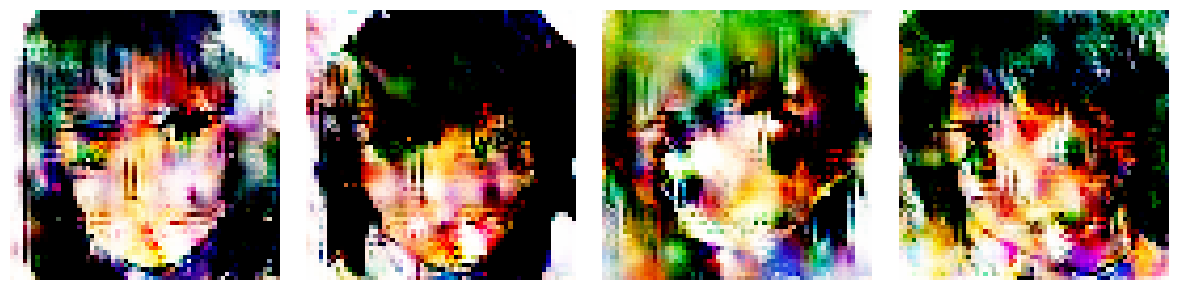

Epoch 300 | D loss: 0.6778 | D acc: 0.6220 | G loss: 0.8568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


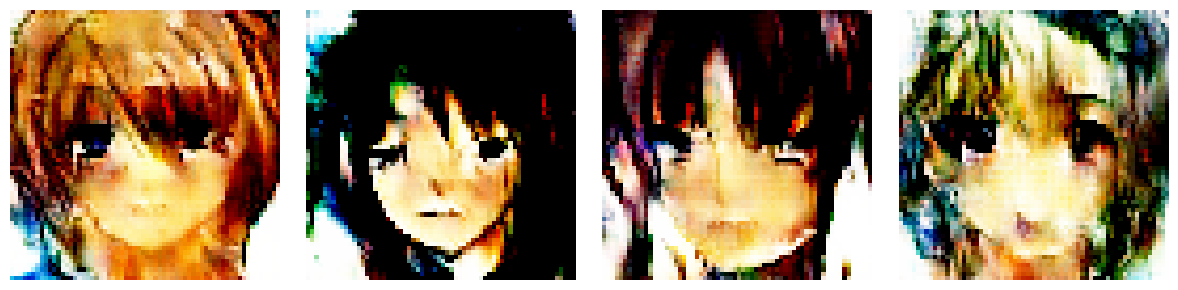

Epoch 600 | D loss: 0.6755 | D acc: 0.6255 | G loss: 0.8628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


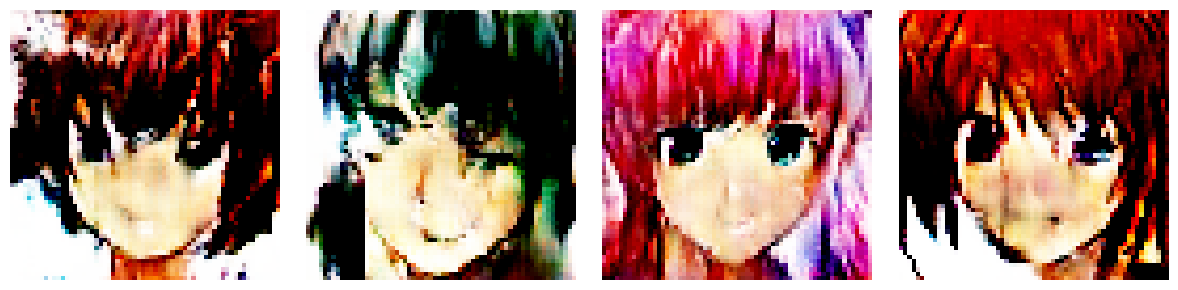

Epoch 900 | D loss: 0.6708 | D acc: 0.6297 | G loss: 0.8769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


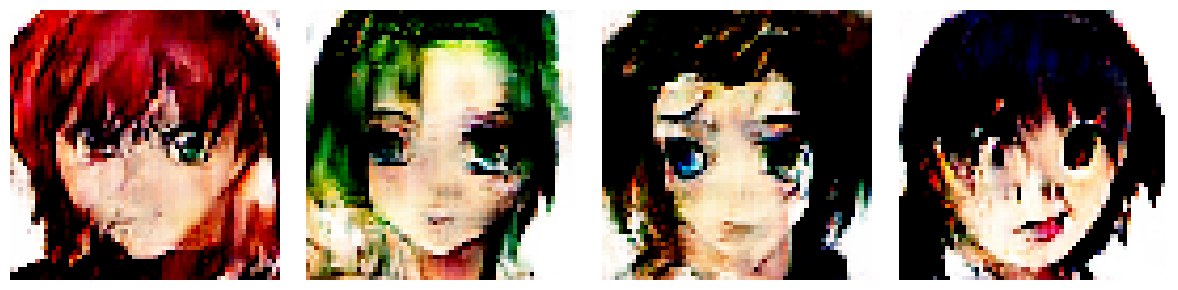

Epoch 1200 | D loss: 0.6668 | D acc: 0.6366 | G loss: 0.8938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


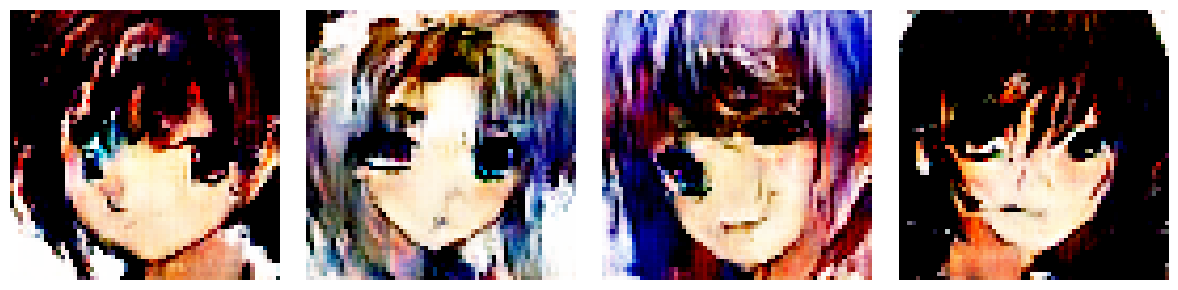

Epoch 1500 | D loss: 0.6589 | D acc: 0.6445 | G loss: 0.9246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


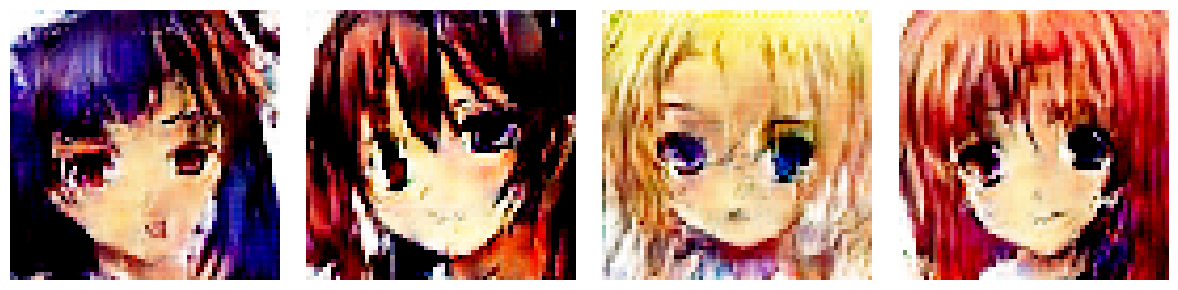

Epoch 1800 | D loss: 0.6476 | D acc: 0.6557 | G loss: 0.9719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


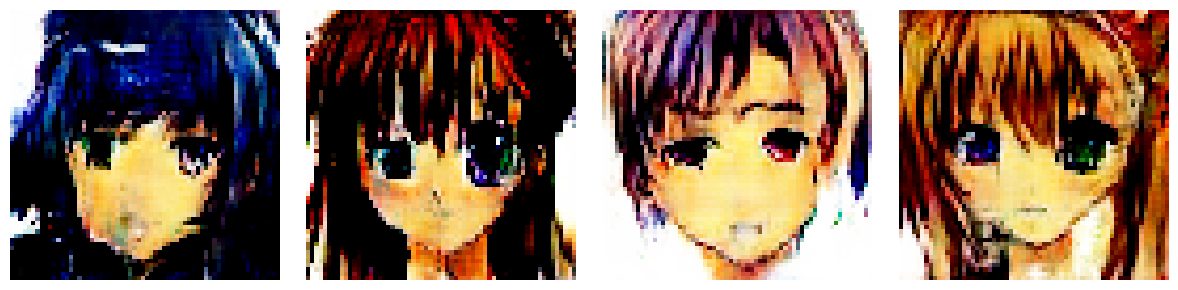

Epoch 2100 | D loss: 0.6320 | D acc: 0.6697 | G loss: 1.0358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


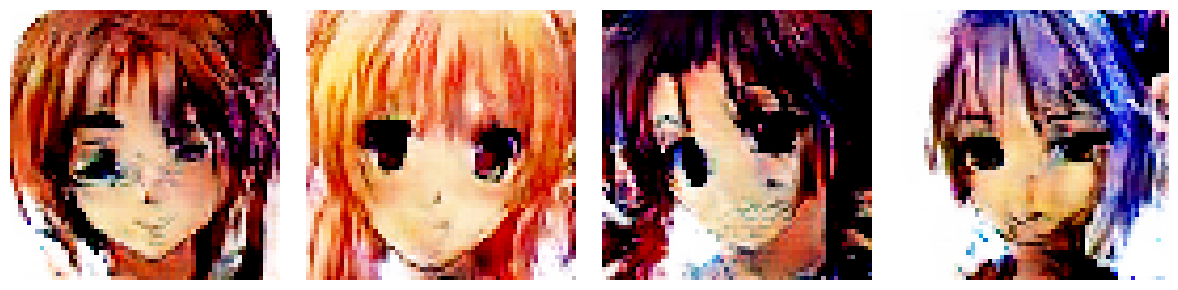

Epoch 2400 | D loss: 0.6073 | D acc: 0.6871 | G loss: 1.1458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


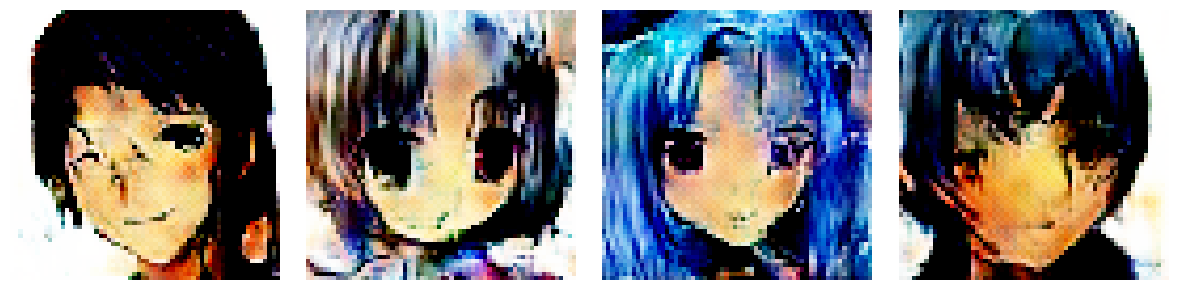

Epoch 2700 | D loss: 0.5776 | D acc: 0.7064 | G loss: 1.2894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


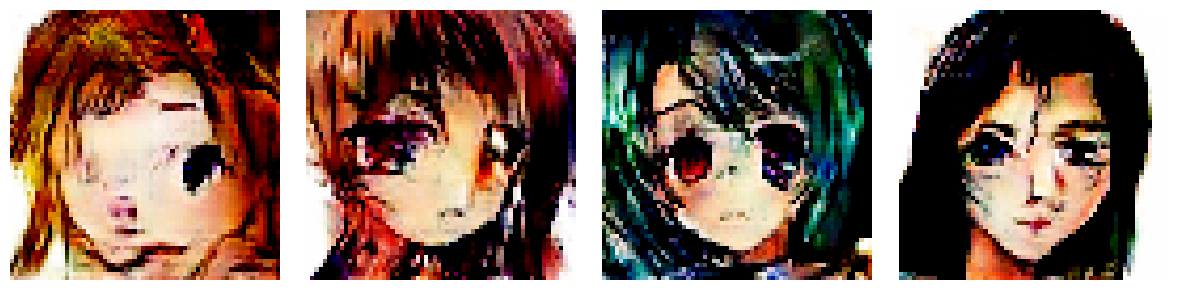

Epoch 3000 | D loss: 0.5435 | D acc: 0.7265 | G loss: 1.4717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


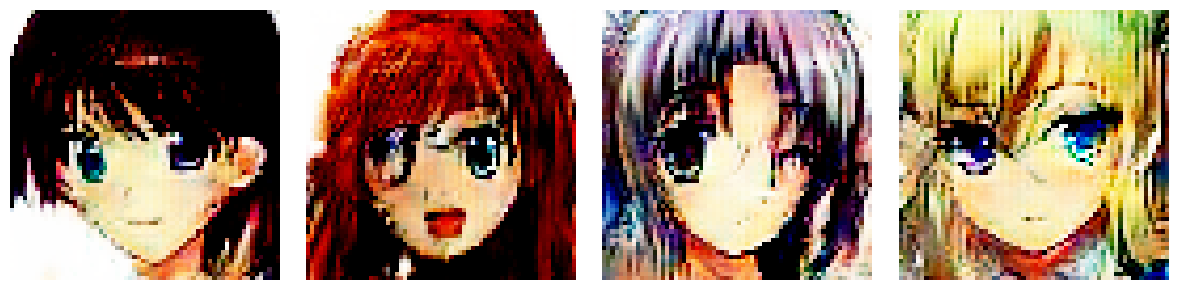

Epoch 3300 | D loss: 0.5105 | D acc: 0.7453 | G loss: 1.6676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


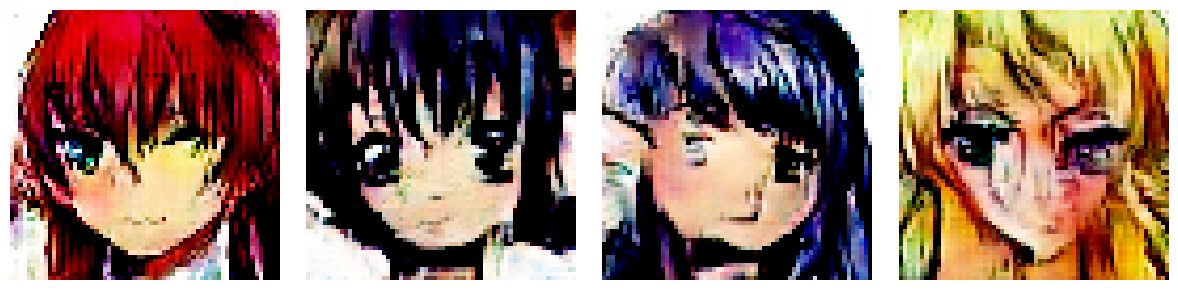

Epoch 3600 | D loss: 0.4786 | D acc: 0.7628 | G loss: 1.8931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


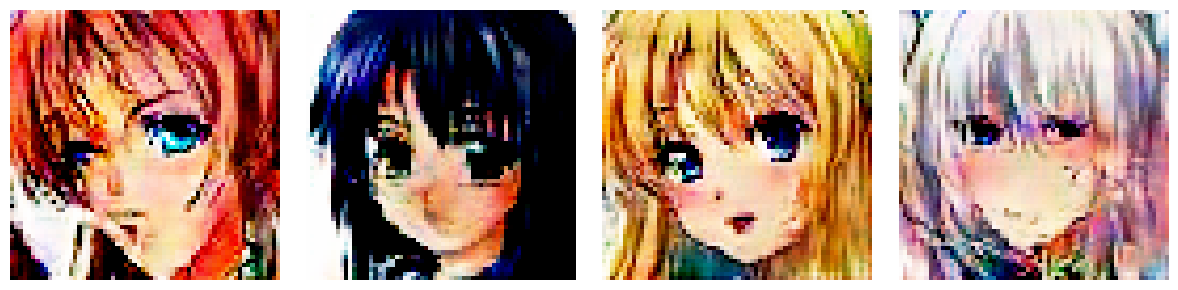

Epoch 3900 | D loss: 0.4494 | D acc: 0.7785 | G loss: 2.1218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


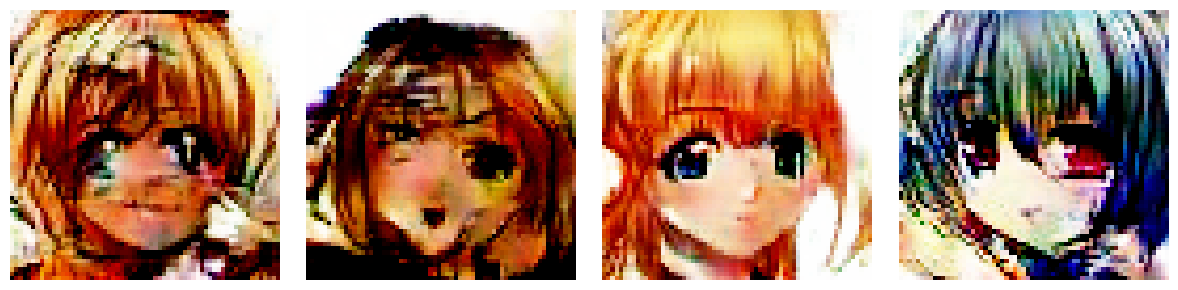

Epoch 4200 | D loss: 0.4225 | D acc: 0.7925 | G loss: 2.3695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


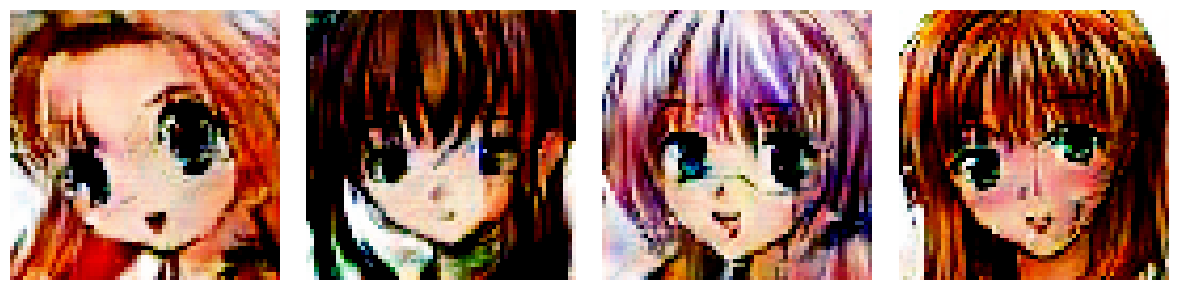

Epoch 4500 | D loss: 0.4191 | D acc: 0.7969 | G loss: 2.4350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


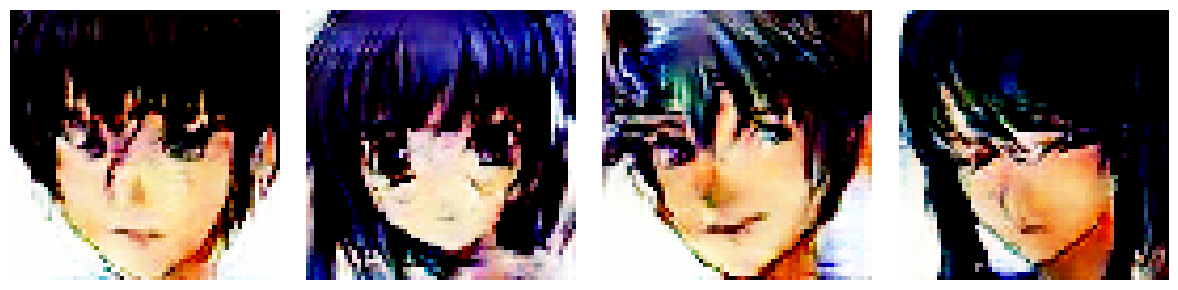

Epoch 4800 | D loss: 0.3982 | D acc: 0.8078 | G loss: 2.6154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


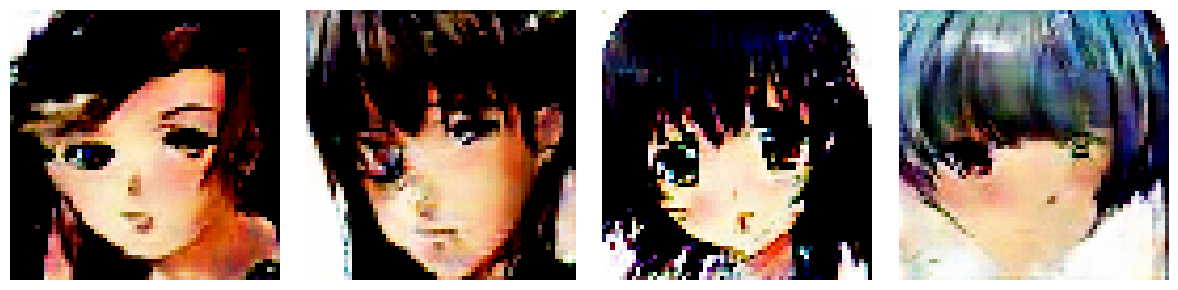

Epoch 5100 | D loss: 0.3797 | D acc: 0.8174 | G loss: 2.8171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


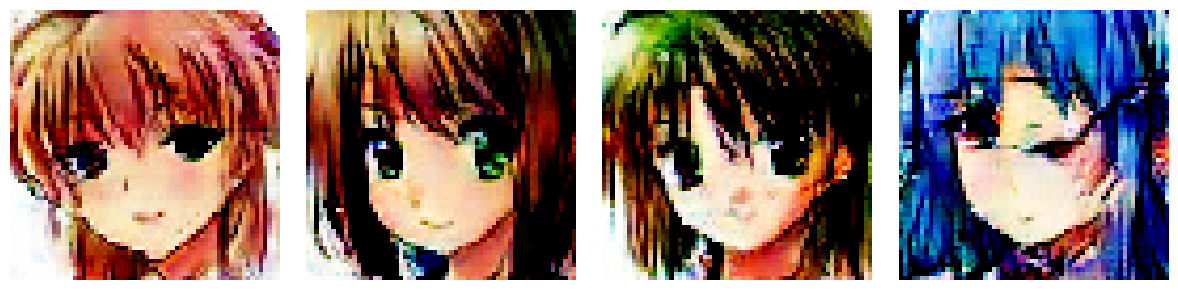

Epoch 5400 | D loss: 0.3608 | D acc: 0.8269 | G loss: 3.0561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


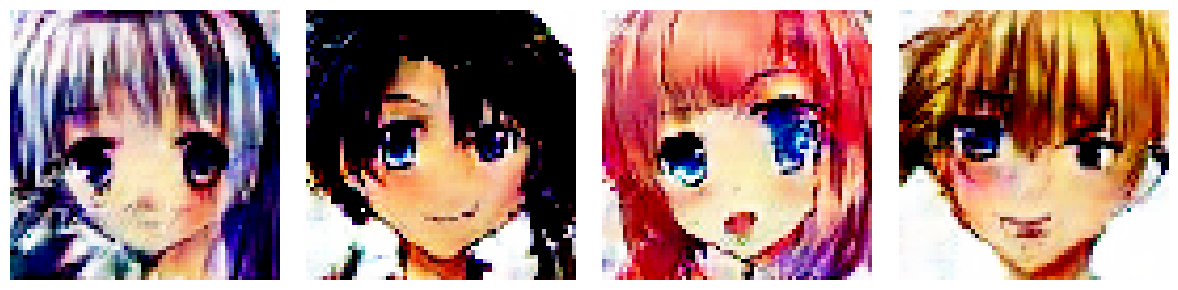

Epoch 5700 | D loss: 0.3436 | D acc: 0.8354 | G loss: 3.2984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


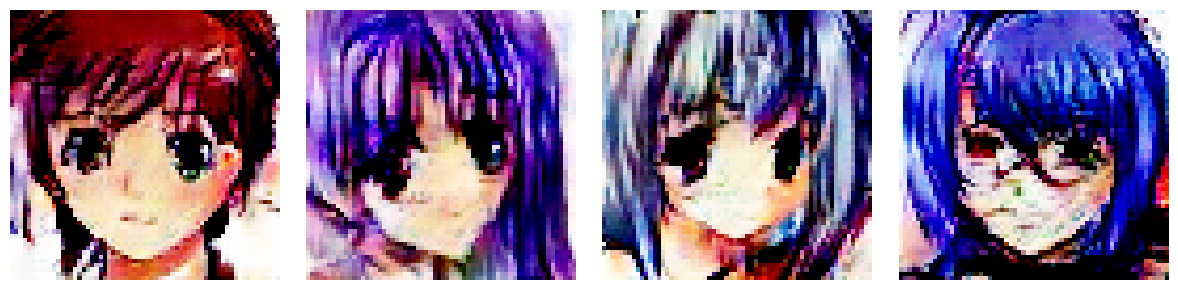

Epoch 6000 | D loss: 0.3304 | D acc: 0.8423 | G loss: 3.4640
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


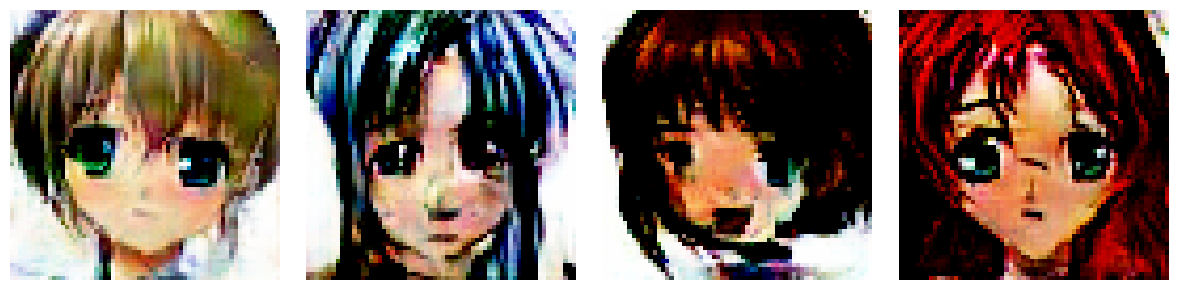

Epoch 6300 | D loss: 0.3162 | D acc: 0.8494 | G loss: 3.6575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


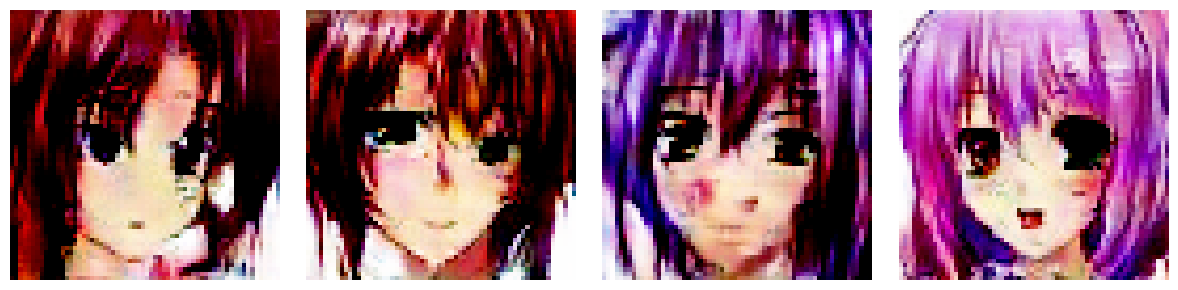

Epoch 6600 | D loss: 0.3031 | D acc: 0.8558 | G loss: 3.8630
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


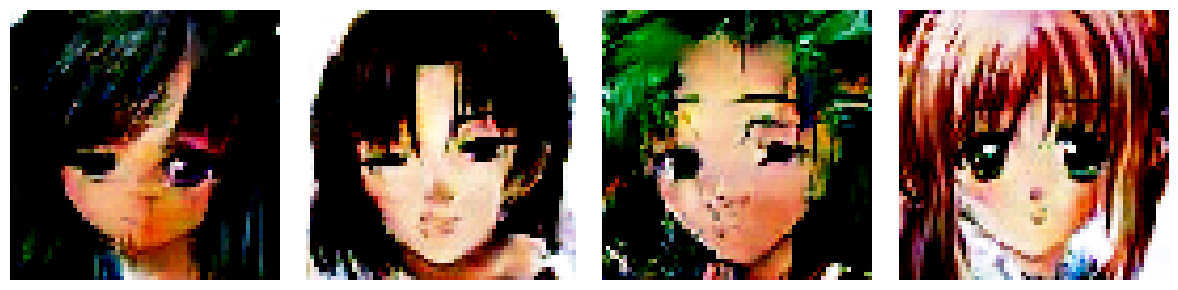

Epoch 6900 | D loss: 0.2908 | D acc: 0.8618 | G loss: 4.0706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


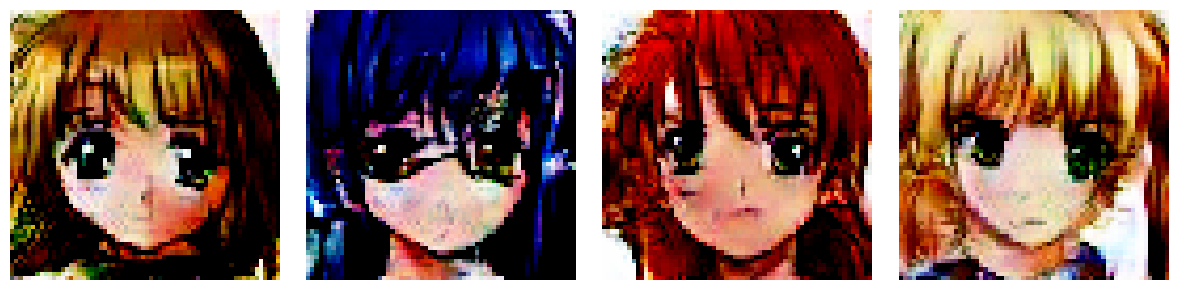

Epoch 7200 | D loss: 0.2795 | D acc: 0.8673 | G loss: 4.2703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


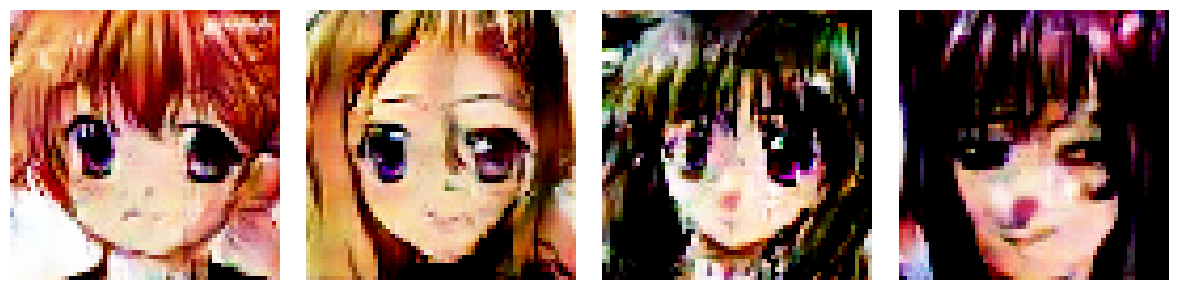

Epoch 7500 | D loss: 0.2779 | D acc: 0.8695 | G loss: 4.3794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


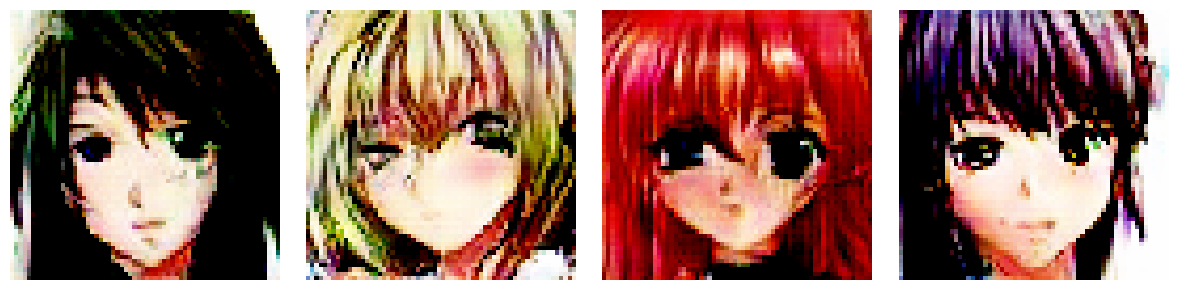

Epoch 7800 | D loss: 0.2769 | D acc: 0.8710 | G loss: 4.3408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


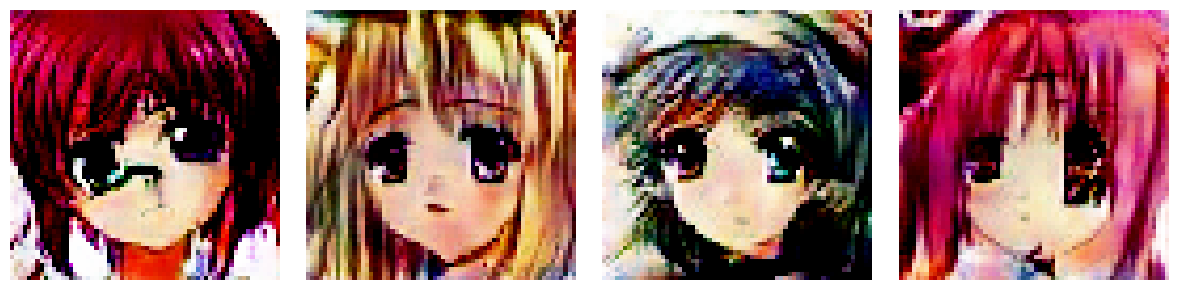

Epoch 8100 | D loss: 0.2678 | D acc: 0.8754 | G loss: 4.4699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


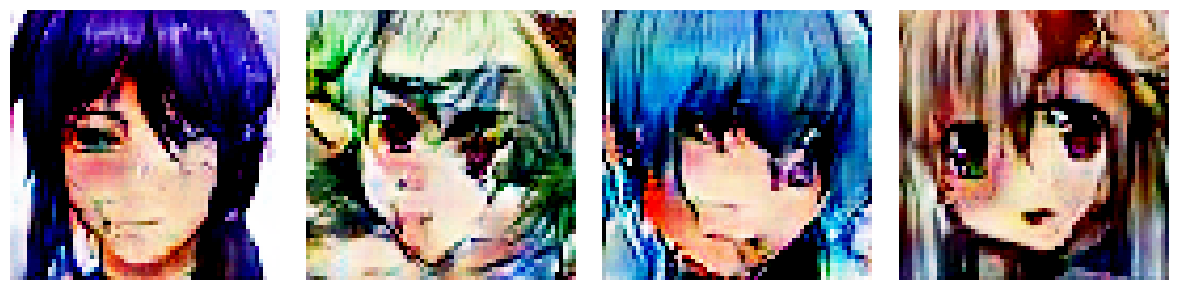

Epoch 8400 | D loss: 0.2590 | D acc: 0.8795 | G loss: 4.6296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


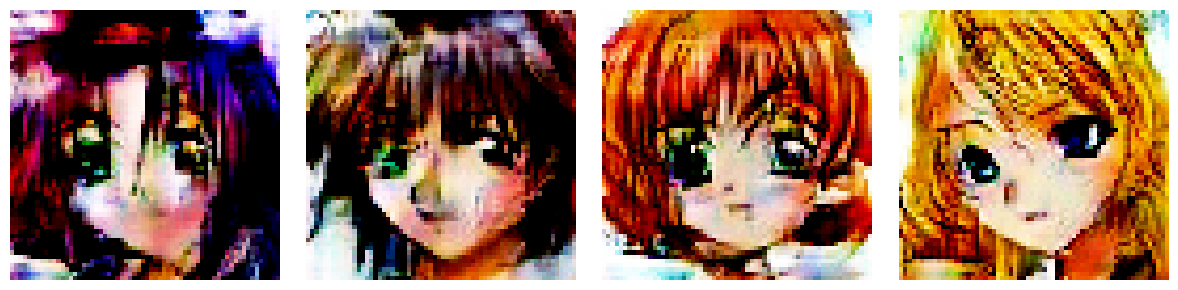

Epoch 8700 | D loss: 0.2508 | D acc: 0.8835 | G loss: 4.8005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


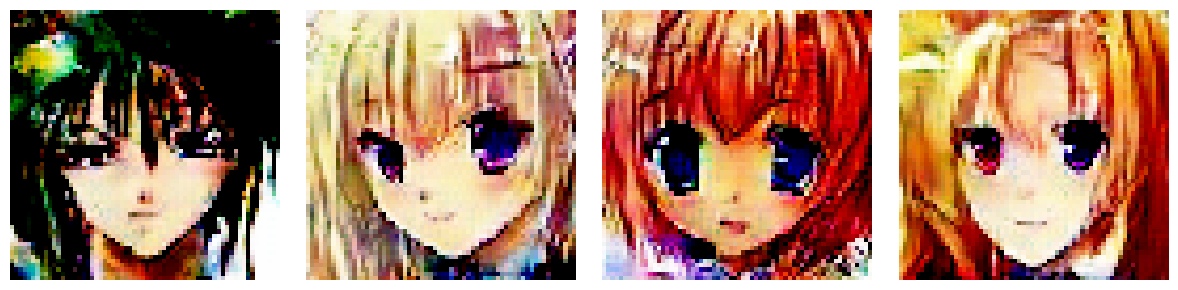

Epoch 9000 | D loss: 0.2431 | D acc: 0.8872 | G loss: 4.9617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


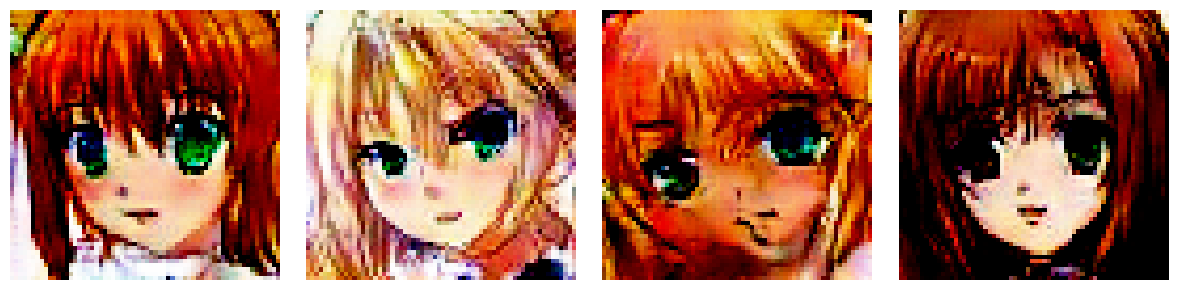

KeyboardInterrupt: 

In [51]:
epochs = 10000

# Bucle de entrenamiento
for epoch in range(epochs):
    # === Entrenar discriminador ===
    # 1. Obtener imágenes reales del generador
    real_images = next(train_generator)[0]

    # 2. Generar imágenes falsas
    z = generateLatentDim()
    fake_images = generator.predict(z, verbose=0)

    # 3. Crear etiquetas: 1 para reales, 0 para falsas
    real_labels = np.ones((real_images.shape[0], 1))
    fake_labels = np.zeros((fake_images.shape[0], 1))

    # 4. Combinar y mezclar
    combined_images = np.concatenate([real_images, fake_images], axis=0)
    combined_labels = np.concatenate([real_labels, fake_labels], axis=0)

    indices = np.arange(combined_images.shape[0])
    np.random.shuffle(indices)

    shuffled_images = combined_images[indices]
    shuffled_labels = combined_labels[indices]

    # 5. Entrenar discriminador con batch mezclado
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(shuffled_images, shuffled_labels)

    # === Entrenar generador ===
    z = generateLatentDim()
    trick_labels = np.ones((batch_size, 1))  # queremos que el discriminador crea que son reales
    discriminator.trainable = False
    g_loss = gan.train_on_batch(z, trick_labels)

    # Mostrar progreso
    if epoch % 300 == 0:
        print(f"Epoch {epoch} | D loss: {d_loss[0]:.4f} | D acc: {d_loss[1]:.4f} | G loss: {g_loss:.4f}")
        mostrar_imagenes_generadas(generator)


### Comprobar resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


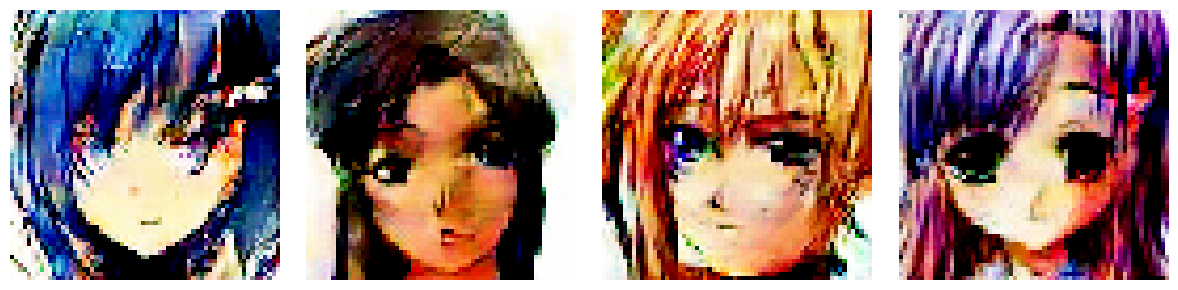

In [54]:
mostrar_imagenes_generadas(generator)

In [55]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
os.makedirs("models/"+timestamp, exist_ok=True)
generator_path = f"models/{timestamp}/Generator.keras"
discriminator_path = f"models/{timestamp}/Discrimiator.keras"

# Save the model
generator.save(generator_path)
discriminator.save(discriminator_path)

In [57]:
def guardar_imagenes_en_csv(imagenes_grises):
    """
    Guarda imágenes en escala de grises en un CSV con columnas: id, 0, ..., 4095.

    Args:
        imagenes_grises: array de forma (200, 64, 64) con imágenes en escala de grises.
        nombre_csv: nombre del archivo CSV a guardar.
    """
    num_imagenes = imagenes_grises.shape[0]
    pixeles_por_imagen = imagenes_grises.shape[1] * imagenes_grises.shape[2]

    # Aplanar cada imagen a un vector de 4096 elementos
    imagenes_aplanadas = imagenes_grises.reshape(num_imagenes, pixeles_por_imagen)

    # Crear DataFrame con columnas: id, 0, ..., 4095
    columnas = ['ID'] + [str(i) for i in range(pixeles_por_imagen)]
    datos = np.column_stack((np.arange(1, num_imagenes + 1), imagenes_aplanadas))
    df = pd.DataFrame(datos, columns=columnas)

    # Guardar en CSV
    os.makedirs("submissions", exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
    df.to_csv("submissions/GAN_"+timestamp+".csv", index=False)


guardar_imagenes_en_csv(generar_imagenes(generator, num_imagenes=200))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def mostrar_imagenes_desde_csv(ruta_csv, num_imagenes=16):
    """
    Carga imágenes en escala de grises desde un CSV y las muestra en un subplot.

    Args:
        ruta_csv: ruta al archivo CSV que contiene las imágenes.
        num_imagenes: número de imágenes a mostrar (por defecto 16).
    """
    # Cargar el CSV
    df = pd.read_csv(ruta_csv)

    # Eliminar la columna 'ID' si existe
    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])

    # Convertir a array y reestructurar
    imagenes = df.values.reshape(-1, 64, 64)

    # Mostrar imágenes en un grid
    cols = int(np.sqrt(num_imagenes))
    rows = int(np.ceil(num_imagenes / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(num_imagenes):
        axes[i].imshow(imagenes[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Imagen {i+1}")

    # Ocultar ejes sobrantes si hay menos imágenes que subplots
    for j in range(num_imagenes, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
